## notebook detailing the PC algorithm wrapper: PCalgWrapper.py

In [58]:
# the PC algorithm is part of the Java Tetrad causal search suite,
# repository here: https://github.com/cmu-phil/tetrad
# and project website here: https://sites.google.com/view/tetradcausal
# Specifically we use the Tetrad command line wrapper: https://github.com/bd2kccd/causal-cmd

# We include in our repository the Tetrad command line version we use in Sanchez-Romero et al.(2023)
# Importantly, it includes the PC modification where we remove some of the orientation rules
# assuming acyclicity in the true model (see Sanchez-Romero et al.(2023) for details).

# we provide here an example of a detailed PC algorithm run

# Ruben Sanchez-Romero 2023

In [59]:
import sys
import os
import numpy as np
import h5py
import subprocess
import matplotlib.pyplot as plt

### single PC run
The idea of the PCalgWrapper is to create a string containing PC run commands and call if from system command line. Then transform the output (list of edges) into matrix form.

#### build the string with PC commands

In [47]:
# when using Tetrad is recommended to use full paths
# adjust paths as necessary!!

current_dir = os.getcwd()

# 1. PC requires the dataset [timepoints x variables] to be pass as a comma-separated txt file

# download an example hcp bold data subject
file_name = f'{current_dir}/hcpData/100206_hcpData.h5'
f = h5py.File(file_name, 'r')
bold_data = np.asarray(f['rest_data']).T # transpose to get [timepoints x variables]
# convert the data into a comma-separated txt file and save temporarly
input_data = f'{current_dir}/temp/example_temp.txt'
np.savetxt(input_data, bold_data, fmt='%0.6f', delimiter=',')        

# 2. Define output file dir and name

out_dir = f'{current_dir}/temp'
out_name = 'PCgraph_temp'  # this is used by Tetrad and needs to be only the file name, no path, no extension!

# 3. Define the path where the command line Tetrad Java file is located

tetrad_path = f'{current_dir}/tetrad_causal-cmd-1.1.3/causal-cmd-1.1.3-jar-noMeekRules234.jar'
        
# 4. Define the PC algorithm parameters. See Sanchez-Romero et al.(2023) for details.

algorithm = 'pc-all'
alpha = 0.01
test = 'fisher-z-test'  #z-test conditional independence
depth = -1  # maximum size of the conditioning set, -1 is all the variables
# Use collider MaxP heuristics from Ramsey (2016) https://arxiv.org/abs/1610.00378
# Collider discovery: 1 = Lookup from adjacency sepsets, 2 = Conservative (CPC), 3 = Max-P
collider_discovery_rule = 3                
# Collider conflicts: 1 = Overwrite, 2 = Orient bidirected, 3 = Prioritize existing colliders
conflict_rule = 3                     
# input-output parameters
data_type = 'continuous'
delimiter = 'comma'
# others
thread = '360'  #for parallelization, usually equal to the number of variables

# 5. Form the string to call it from system

call_PC = (
          f'java -Xmx20G -jar {tetrad_path} ' #Xmx**G is used to allocate memory, increase or decrease accordingly
          f'--thread {thread} '
          f'--algorithm {algorithm} ' 
          f'--stableFAS '  # This runs the order independent PC version from Colombo and Maathuis (2014) https://jmlr.org/papers/v15/colombo14a.html
          f'--concurrentFAS '  # to run in parallel when possible
          f'--test {test} '
          f'--alpha {alpha} '
          f'--depth {depth} '
          f'--colliderDiscoveryRule {collider_discovery_rule} '
          f'--conflictRule {conflict_rule} '
          f'--dataset {input_data} '
          f'--no-header ' # do not use if your data contain headers, ie. 1st row with variable names
          f'--data-type {data_type} ' 
          f'--delimiter {delimiter} '
          f'--out {out_dir} '
          f'--prefix {out_name} '
          f'--skip-latest  '  # to avoid checking if there is a new Tetrad version
          )
# print to check it looks correct
print(call_PC)

java -Xmx20G -jar DirectedActflow_release/tetrad_causal-cmd-1.1.3/causal-cmd-1.1.3-jar-noMeekRules234.jar --thread 360 --algorithm pc-all --stableFAS --concurrentFAS --test fisher-z-test --alpha 0.01 --depth -1 --colliderDiscoveryRule 3 --conflictRule 3 --dataset DirectedActflow_release/temp/example_temp.txt --no-header --data-type continuous --delimiter comma --out DirectedActflow_release/temp --prefix PCgraph_temp --skip-latest  


### run call_PC from system command line

In [49]:
# run as is to avoid having temporary output printed in the notebook
p = subprocess.call(call_PC,
                    shell=True,
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.STDOUT)
# if want to print the temporary output
#p = subprocess.call(call_PC,shell=True)

# print if there was an error in the PC run
if p != 0:
    print(f'{p}, error in the PC run')
    print(f' copy call from above and run it from a terminal window')
else:
    print(f'PC graph for {input_data} in {out_dir}/{out_name}.txt')
# TODO print the Tetrad error here. As of today, in case of error I copy the string and call it directly from
# a terminal window (outside the notebook) to see the error.

PC graph for DirectedActflow_release/temp/example_temp.txt in DirectedActflow_release/temp/PCgraph_temp.txt


### open the PC output and transform it into a connectivity matrix

(360, 360)


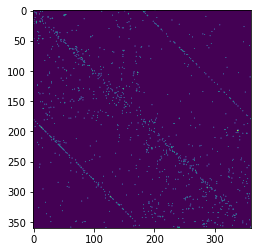

In [61]:
# the PCalgWrapper contains a function to open the PC graph and transfrom it into a connectivity matrix
# tetrad2matrix encodes directed edges X->Y as 2 (M(y,x) = 2, direction column to row) 
# and undirected X--Y as 1 (for M(x,y) = M(y,x) = 1)

from PCalgWrapper import tetrad2matrix

output_graph_file = f'{out_dir}/{out_name}.txt'
graph_matrix = tetrad2matrix(output_graph_file)
print(graph_matrix.shape)
plt.imshow(graph_matrix)